In [53]:
import perceval as pcvl
import perceval.components as comp
import numpy as np
import networkx as nx
from scipy.linalg import sqrtm
from perceval.algorithm import Sampler
from scipy.special import binom
import itertools

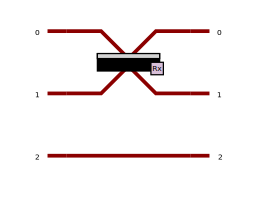

In [52]:
example_circuit = pcvl.Circuit(3)
example_circuit.add((0,1), pcvl.BS())
pcvl.pdisplay(example_circuit)

In [76]:
unitary_matrix = pcvl.Matrix([[0, 0, 1],
                [0, 1, 0],
                [1, 0, 0]])

In [77]:
#circuit_from_matrix = comp.Unitary(U=unitary_matrix)

In [78]:
#pcvl.pdisplay(circuit_from_matrix)

In [80]:
'''
Step 1: Get Matrix of overall graph 
Unitary of Matrix 
    Step 2: Get all possible sub graphs (of size K) 
    Step 3: Calculate permanents for each sub graph
    Step 4: Find the maximum permanents -> Density
'''

'\nStep 1: Get Matrix of overall graph \nUnitary of Matrix \n    Step 2: Get all possible sub graphs (of size K) \n    Step 3: Calculate permanents for each sub graph\n    Step 4: Find the maximum permanents -> Density\n'

In [81]:
def to_unitary(A):
    ''' Input: graph A either as:
                                 an adjacency matrix of size mxm
                                 a networkX graph with m nodes
        Output: unitary with size 2mx2m
    '''

    if type(A) == type(nx.Graph()):
        A = nx.to_numpy_array(A)
    P1, D, V = np.linalg.svd(A)

    c = np.max(D)
    # if it is not complex, then np.sqrt will output nan in complex values
    An = np.matrix(A/c, dtype=complex)
    P = An
    m = len(An)
    Q = sqrtm(np.identity(m)-np.dot(An, An.conj().T))
    R = sqrtm(np.identity(m)-np.dot(An.conj().T, An))
    S = -An.conj().T
    Ubmat = np.bmat([[P, Q], [R, S]])
    Ubmat = Ubmat.real #to eliminate those 
    return (np.copy(Ubmat), c)

In [82]:
def input_state(m):
    '''input state for selection of our m modes
        returns |1,1,1,...,0,0,0> m ones and m zeros'''
    return np.append(np.ones(m), np.zeros(m)).astype(int)

In [83]:
# Post selection of samples with photons only on first half modes
def post_select(samples):
    ''''post select on states that have all modes from m to 2*m as vacuum
        can't have collision of first half'''
    a = []
    m = int(len(samples[0])/2)
    for state in samples:
        state = list(state)
        if all(ele == state[m-1] for ele in state[:m]) and state[m-1] == 1:
            # do not need to check if there is vacuum in the second half for several reasons!
            a.append(state)
    return a

In [84]:
def perm_estimation(G, nb_samples, Ns_min=0):
    if Ns_min == 0:
        Ns_min = nb_samples

    if type(G) == type(nx.Graph()):
        m = G.number_of_nodes()
    else:
        m = len(G)
    in_state = input_state(m)

    U, c = to_unitary(G)
    U_matrix_pcvl = pcvl.Matrix(U)
    unitary_component = comp.Unitary(U_matrix_pcvl)
    proc = pcvl.Processor("CliffordClifford2017", unitary_component)
    proc.with_input(pcvl.BasicState(in_state))

    samples_accepted = []
    i = 0
    sampler = Sampler(proc)
    while len(samples_accepted) < Ns_min:
        samples = list(sampler.samples(nb_samples)['results'])
        samples_accepted += post_select(samples)
        i = i+1
    print("Total number of samples: ", nb_samples*i)
    print("Number of samples post:", len(samples_accepted))
    perm = (c**m)*np.sqrt(len(samples_accepted)/(nb_samples*i))
    return perm, samples

In [85]:
# Functions to generate the subgraphs to test
def construct_B(G, subG, k):
    ''' inputs: 
                G - networkX graph 
                subG - list of nodes for selected subgraph
                k - integer for size of subgraph to find
        return:
                matrix B containing all possible subgraphs of size k - dimensions are k*len(sub_m), k*len(sub_m)'''

    G_n = len(G.nodes)
    subG_n = len(subG)
    num_subgraphs = int(binom(G_n-subG_n, k-subG_n))
    print("Number of combinations for subgraphs:", num_subgraphs)

    nodes = list(G.nodes)
    test_nodes = [node for node in nodes if node not in subG]
    test_list = list(itertools.combinations(test_nodes, k-subG_n))

    poss_subg = [subG+list(i) for i in test_list]

    # Construction of B
    sub_m = [nx.convert_matrix.to_numpy_array(
        G.subgraph(sub_nodes)) for sub_nodes in poss_subg]
    B = np.zeros((k*num_subgraphs, k*num_subgraphs))
    for i, j in enumerate(sub_m):
        B[k*i:k*i+k, 0:k] = j
    return (B, poss_subg)

In [86]:
def densest_subgraphs(G, seed, k, nb_samples, Ns_min=100):
    '''Input: G - networkX graph to test 
              Ns - number of samples to generate with quantum device
              seed - subgraph identified from optimized classical algorithm
    return: subgraphs by order of selection'''

    # Initialization and preparing the device
    B = construct_B(G, seed, k)
    in_state = input_DS(int(len(B[0])/k), k)
    U, c = to_unitary(B[0])

    unitary_component = comp.Unitary(pcvl.Matrix(U))
    proc = pcvl.Processor("CliffordClifford2017", unitary_component)
    proc.with_input(pcvl.BasicState(in_state))

    # generating samples
    samples = []
    i = 0
    sampler = Sampler(proc)
    while len(samples) < Ns_min:
        samples_device = sampler.samples(nb_samples)['results']
        new_generation_samples = post_selectionDS(samples_device, k)
        samples += new_generation_samples
        i = i+1

    timesG = np.zeros(len(B[1]))
    print("Number of samples: ", len(samples), "\nTotal samples generated:", nb_samples*i)
    for sample in samples:
        indexG = list(sample).index(1)
        timesG[int(indexG/k)] = timesG[int(indexG/k)]+1
    return sorted(zip(timesG, B[1]), reverse=True)

In [87]:
def input_DS(m, k):
    '''input state for selection columns
             m - number of subgraphs
             k - size of each subgraph (size to identify)
        returns |1,1,1,...,0,0,0> k ones and k*m-k zeros'''
    return np.append(np.append(np.ones(k), np.zeros(k*m-k)), np.zeros(k*m)).astype(int)

In [88]:
def post_selectionDS(samples, k):
    n_subg = int(len(samples[0])/2/k)
    accepted = [sample for sample in samples for i in range(n_subg) if all(sample[k*i:k*i+k]) == 1]
    return accepted

#### 1) Define Graph

In [89]:
n_nodes = 7
p1 = 0.7

In [90]:
graph = nx.erdos_renyi_graph(n=6,p=0.7)

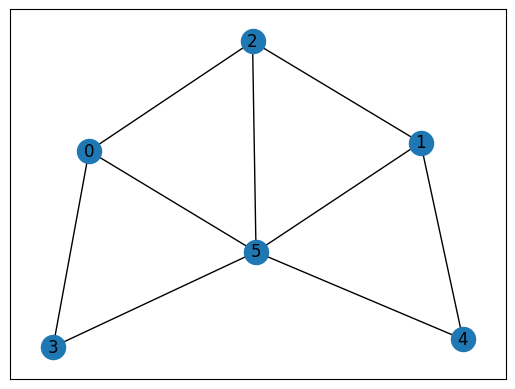

In [91]:
nx.draw_networkx(graph)

#### 2) Permanent Estimaton

In [92]:
Ns = 5 #number of samples to generate
perm, samples = perm_estimation(graph, Ns)

Total number of samples:  96665
Number of samples post: 5


In [93]:
perm

8.057580711790312

#### 2) Densest Subgraph estimation

In [94]:
res = densest_subgraphs(graph, seed=[4], k=3, nb_samples=100, Ns_min=100)

Number of combinations for subgraphs: 10
Number of samples:  100 
Total samples generated: 78800


In [95]:
densest_subgraphs

<function __main__.densest_subgraphs(G, seed, k, nb_samples, Ns_min=100)>

In [96]:
res

[(100.0, [4, 1, 5]),
 (0.0, [4, 3, 5]),
 (0.0, [4, 2, 5]),
 (0.0, [4, 2, 3]),
 (0.0, [4, 1, 3]),
 (0.0, [4, 1, 2]),
 (0.0, [4, 0, 5]),
 (0.0, [4, 0, 3]),
 (0.0, [4, 0, 2]),
 (0.0, [4, 0, 1])]